In [1]:
# Enhanced SMS Spam Detection with Multiple Classifiers
# Import additional libraries for comprehensive analysis

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
import re
import string
import pandas as pd
from wordcloud import WordCloud
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


In [2]:
def preprocess_text(text):
    """
    Enhanced robust text preprocessing function
    Handles NaN, empty strings, and non-string inputs safely
    """
    # Handle missing values or non-string types
    if pd.isna(text):
        return ""
    text = str(text)  # Convert to string just in case
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove phone numbers
    text = re.sub(r'[\+]?[1-9]?[0-9]{7,15}', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# Fit TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    lowercase=True,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)


# 2. Count Vectorization
count_vectorizer = CountVectorizer(
    max_features=5000,
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Example: SMS Spam Collection dataset (download spam.csv beforehand)
data = pd.read_csv("spam.csv", encoding="latin-1")

# Keep only relevant columns
data = data.rename(columns={"v1": "Category", "v2": "Message"})
data = data[["Category", "Message"]]

# Convert labels: ham=0, spam=1
data["Category"] = data["Category"].map({"ham": 0, "spam": 1})

# Apply preprocessing
data["Message_cleaned"] = data["Message"].apply(preprocess_text)

# Assuming your dataset looks like this:
# data["Message_cleaned"] -> preprocessed text
# data["Category"] -> labels (spam/ham as int)
X_cleaned = data["Message_cleaned"]
Y = data["Category"].astype(int)

# Split the data
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(
    X_cleaned, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Training set size: {X_train_clean.shape[0]}")
print(f"Test set size: {X_test_clean.shape[0]}")
print(f"Spam ratio in training: {Y_train_clean.mean():.3f}")
print(f"Spam ratio in test: {Y_test_clean.mean():.3f}")


Training set size: 4457
Test set size: 1115
Spam ratio in training: 0.134
Spam ratio in test: 0.134


In [4]:
# Transform text data using different vectorization techniques

# TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

# Count features
X_train_count = count_vectorizer.fit_transform(X_train_clean)
X_test_count = count_vectorizer.transform(X_test_clean)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Count feature matrix shape: {X_train_count.shape}")

# Display feature names
print(f"\nSample TF-IDF features: {tfidf_vectorizer.get_feature_names_out()[:10]}")
print(f"Sample Count features: {count_vectorizer.get_feature_names_out()[:10]}")


TF-IDF feature matrix shape: (4457, 5000)
Count feature matrix shape: (4457, 5000)

Sample TF-IDF features: ['aathilove' 'aathilove lot' 'abi' 'ability' 'abiola' 'able' 'able come'
 'able deliver' 'able pay' 'abt']
Sample Count features: ['aathilove' 'aathilove lot' 'abi' 'ability' 'abiola' 'able' 'able come'
 'able deliver' 'able pay' 'abt']


In [5]:
# Define Multiple Classifiers for SMS Spam Detection

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

classifiers = {
    'Naive Bayes (Multinomial)': MultinomialNB(alpha=0.1),
    'Naive Bayes (Gaussian)': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Results storage
results = {}

print("Training and evaluating multiple classifiers...")
print("=" * 60)


Training and evaluating multiple classifiers...


In [6]:
# Train and evaluate classifiers with TF-IDF features
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Results with TF-IDF Features:")
print("-" * 40)

for name, classifier in classifiers.items():
    try:
        # Train the classifier
        if name == 'Naive Bayes (Gaussian)':
            # GaussianNB requires dense matrices
            X_train_dense = X_train_tfidf.toarray()
            X_test_dense = X_test_tfidf.toarray()
            classifier.fit(X_train_dense, Y_train_clean)
            y_pred = classifier.predict(X_test_dense)
            y_pred_proba = classifier.predict_proba(X_test_dense)[:, 1]
        else:
            classifier.fit(X_train_tfidf, Y_train_clean)
            y_pred = classifier.predict(X_test_tfidf)
            y_pred_proba = classifier.predict_proba(X_test_tfidf)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(Y_test_clean, y_pred)
        f1 = f1_score(Y_test_clean, y_pred)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'classifier': classifier
        }
        
        print(f"{name:25}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")
        
    except Exception as e:
        print(f"{name:25}: Error - {str(e)}")

print("\n" + "=" * 60)


Results with TF-IDF Features:
----------------------------------------
Naive Bayes (Multinomial): Accuracy = 0.9794, F1-Score = 0.9187
Naive Bayes (Gaussian)   : Accuracy = 0.8610, F1-Score = 0.6301
Logistic Regression      : Accuracy = 0.9677, F1-Score = 0.8636
SVM (Linear)             : Accuracy = 0.9830, F1-Score = 0.9324
SVM (RBF)                : Accuracy = 0.9785, F1-Score = 0.9130
Random Forest            : Accuracy = 0.9758, F1-Score = 0.9004



In [7]:
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['classifier']
best_accuracy = results[best_model_name]['accuracy']
best_f1 = results[best_model_name]['f1_score']

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

print(f"\nDetailed Classification Report for {best_model_name}:")
print("-" * 50)
print(classification_report(
    Y_test_clean,
    results[best_model_name]['predictions'],
    target_names=["Ham", "Spam"]
))



Best Model: SVM (Linear)
Best Accuracy: 0.9830
Best F1-Score: 0.9324

Detailed Classification Report for SVM (Linear):
--------------------------------------------------
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



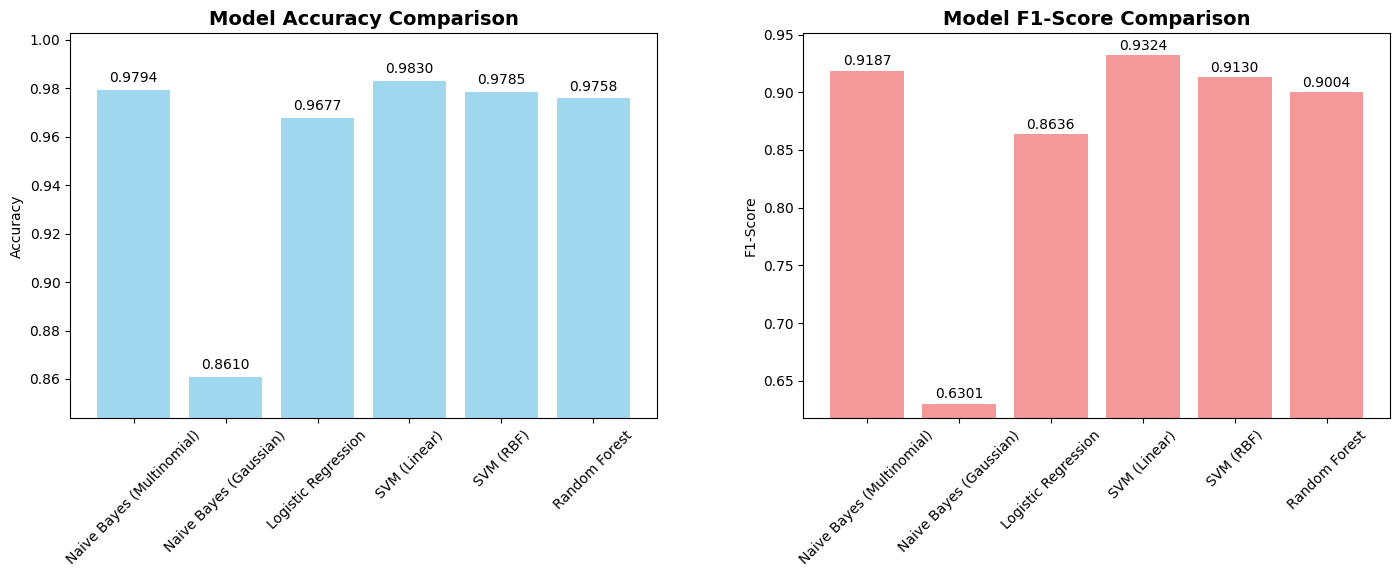

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metrics
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
f1_scores = [results[name]['f1_score'] for name in model_names]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

bars1 = ax1.bar(model_names, accuracies, color='skyblue', alpha=0.8)
ax1.set_ylim(min(accuracies)*0.98, max(accuracies)*1.02)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on top of bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10)


bars2 = ax2.bar(model_names, f1_scores, color='lightcoral', alpha=0.8)
ax2.set_ylim(min(f1_scores)*0.98, max(f1_scores)*1.02)
ax2.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar, f1 in zip(bars2, f1_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{f1:.4f}', ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.92, left=0.07, right=0.95, wspace=0.25)
plt.show()


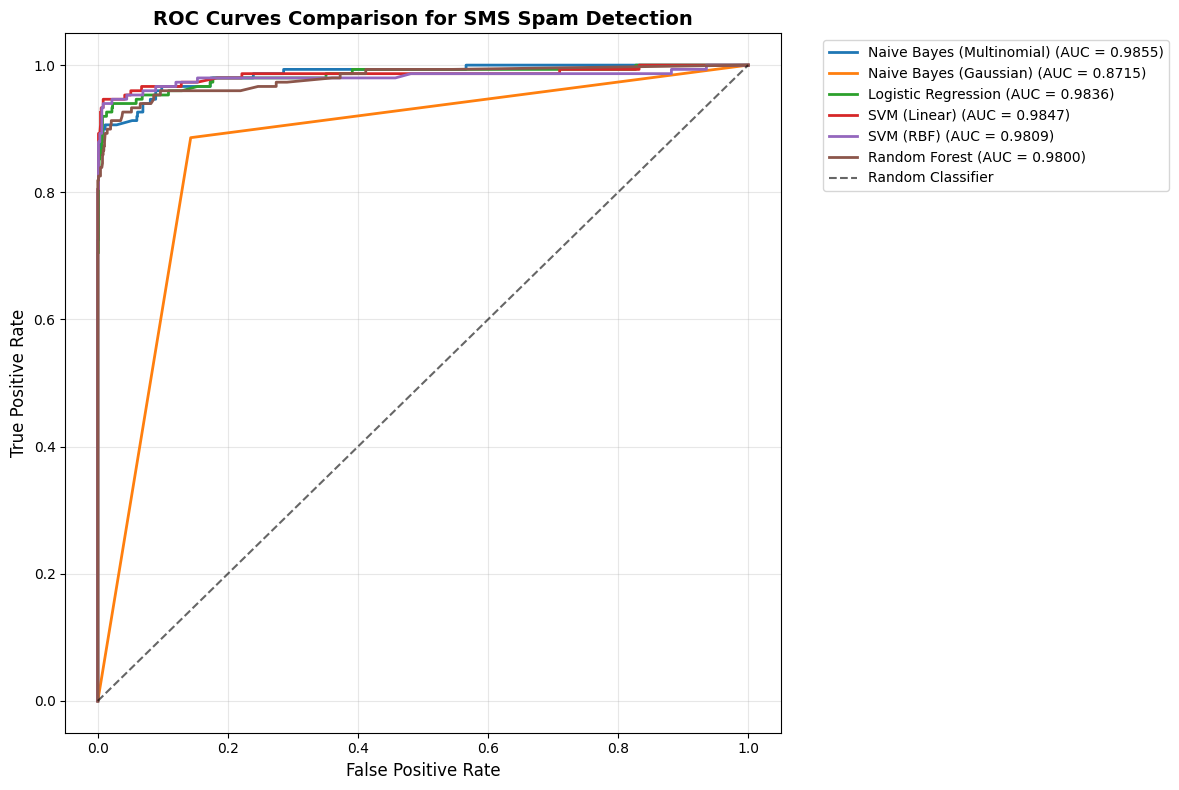

In [9]:
# ROC Curves for All Models
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(12, 8))

for name in results.keys():
    y_pred_proba = results[name]['probabilities']
    fpr, tpr, _ = roc_curve(Y_test_clean, y_pred_proba)
    roc_auc = roc_auc_score(Y_test_clean, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.6)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison for SMS Spam Detection', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


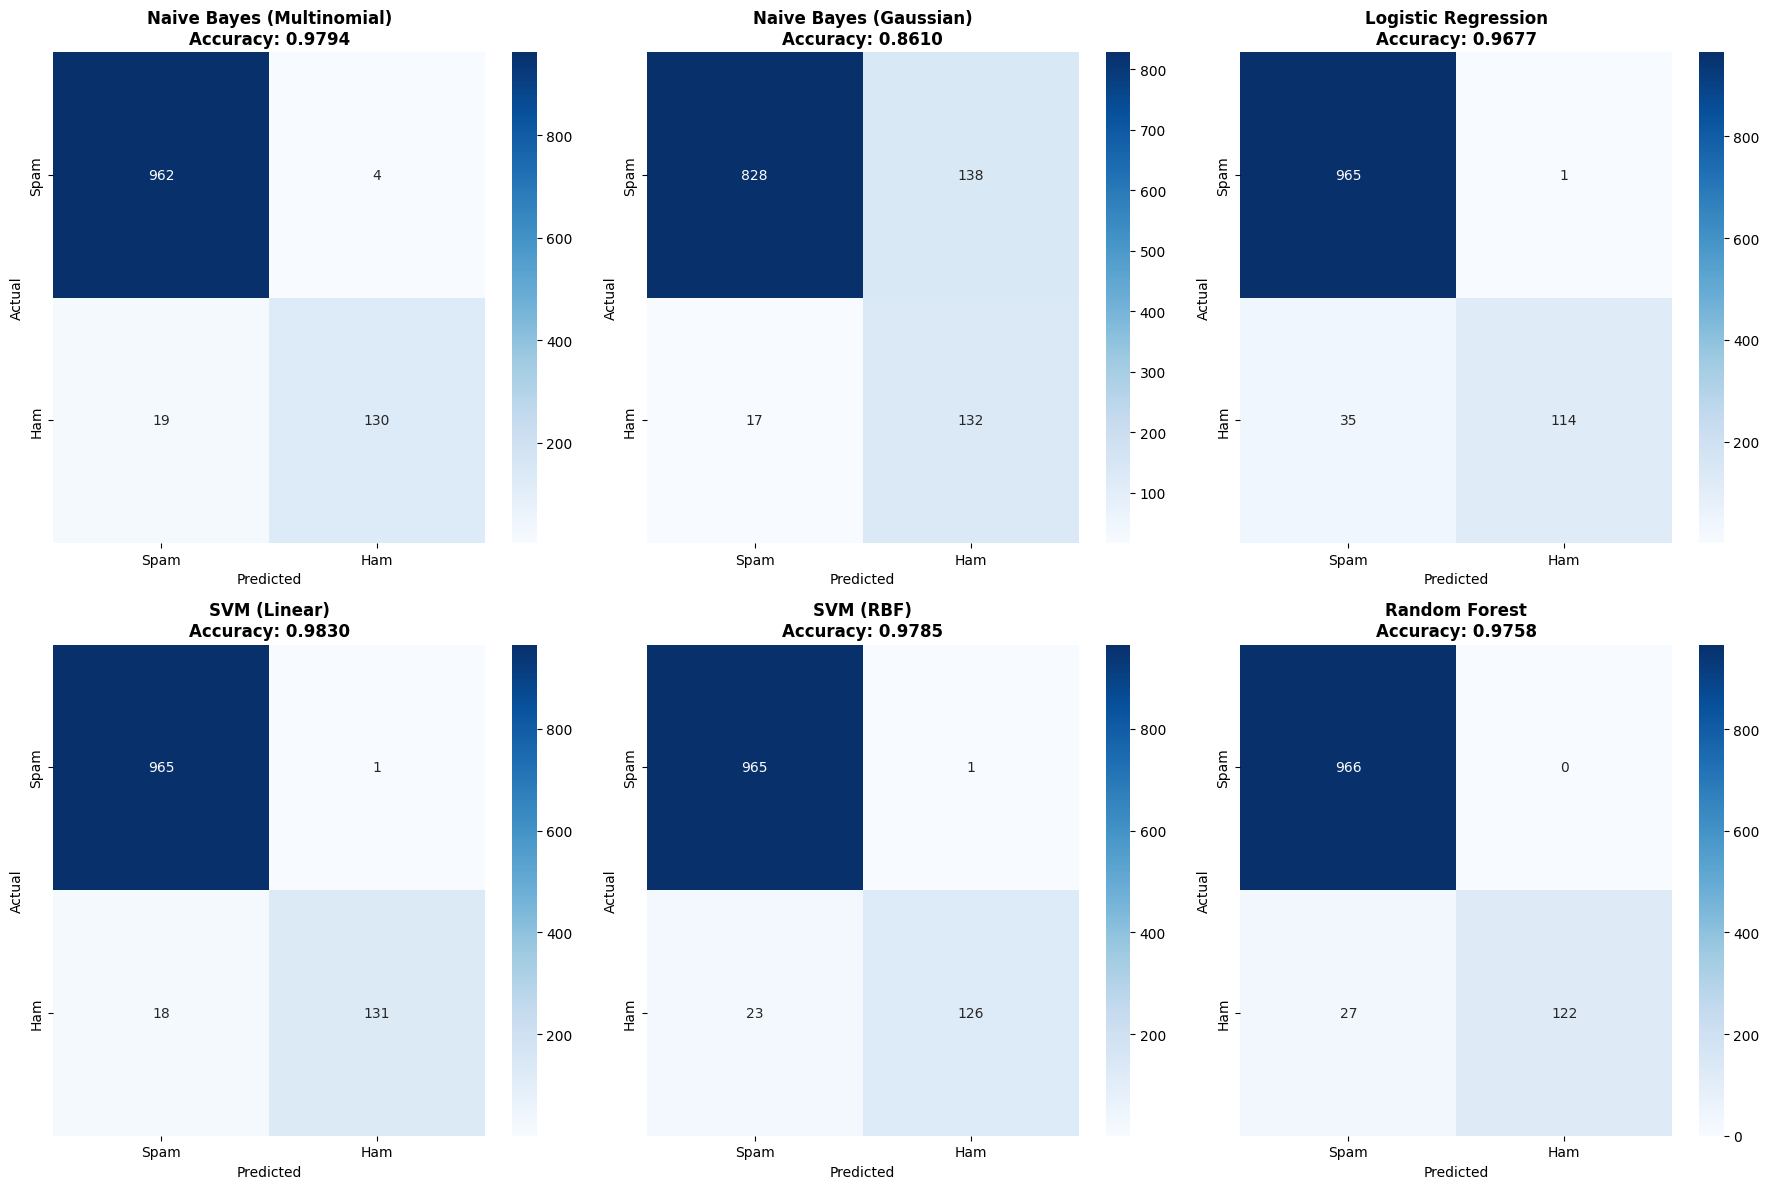

In [10]:
# Confusion Matrices for All Models
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(Y_test_clean, result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Spam', 'Ham'], 
                yticklabels=['Spam', 'Ham'],
                ax=axes[i])
    
    axes[i].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}', 
                     fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [11]:
from collections import Counter
import numpy as np

def display_words_in_columns(text, title, n_columns=3, top_n=30):
    # Split text into words and count frequencies
    words = text.split()
    word_counts = Counter(words)
    
    # Get the top N most common words
    most_common = word_counts.most_common(top_n)
    
    # Prepare list of words
    words_list = [f"{word} ({count})" for word, count in most_common]
    
    # Calculate number of rows for columns
    n_rows = int(np.ceil(len(words_list) / n_columns))
    
    # Split words into columns
    columns = [words_list[i*n_rows:(i+1)*n_rows] for i in range(n_columns)]
    
    # Transpose to print row-wise
    for row in zip(*columns):
        print("{:<25} {:<25} {:<25}".format(*row))
    print("\n" + "-"*80 + "\n")

# Spam messages
spam_messages = ' '.join(data[data['Category'] == 0]['Message_cleaned'])
print("Most Common Words in Spam Messages:")
display_words_in_columns(spam_messages, title="Spam", n_columns=3, top_n=30)

# Ham messages
ham_messages = ' '.join(data[data['Category'] == 1]['Message_cleaned'])
print("Most Common Words in Ham Messages:")
display_words_in_columns(ham_messages, title="Ham", n_columns=3, top_n=30)


Most Common Words in Spam Messages:
i (2185)                  is (728)                  are (409)                
you (1837)                it (590)                  not (406)                
to (1554)                 of (524)                  on (391)                 
the (1119)                for (501)                 at (377)                 
a (1055)                  that (486)                do (377)                 
u (988)                   im (461)                  can (376)                
and (848)                 have (438)                if (347)                 
in (813)                  but (418)                 will (334)               
me (756)                  your (414)                be (332)                 
my (743)                  so (412)                  get (307)                

--------------------------------------------------------------------------------

Most Common Words in Ham Messages:
to (686)                  is (158)                  stop (116)    

In [12]:
# Interactive SMS Spam Detection Function

def predict_sms_spam(message, model_name=None):
    """
    Predict if an SMS message is spam or ham
    
    Args:
        message (str): The SMS message to classify
        model_name (str): Specific model to use. If None, uses the best model
    
    Returns:
        dict: Prediction results with confidence scores
    """
    
    if model_name is None:
        model_name = best_model_name
    
    # Preprocess the message
    cleaned_message = preprocess_text(message)
    
    # Transform using TF-IDF
    message_features = tfidf_vectorizer.transform([cleaned_message])
    
    # Get the model
    model = results[model_name]['classifier']
    
    # Make prediction
    if model_name == 'Naive Bayes (Gaussian)':
        message_features = message_features.toarray()
    
    prediction = model.predict(message_features)[0]
    probabilities = model.predict_proba(message_features)[0]
    
    # Prepare results
    result = {
        'message': message,
        'cleaned_message': cleaned_message,
        'model_used': model_name,
        'prediction': 'SPAM' if prediction == 0 else 'HAM',
        'spam_probability': probabilities[0],
        'ham_probability': probabilities[1],
        'confidence': max(probabilities)
    }
    
    return result

# Test the function with sample messages
test_messages = [
    "Congratulations! You've won $1000! Click here to claim your prize!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your account will be suspended. Verify now: http://fake-bank.com",
    "Thanks for the birthday wishes! See you at the party tonight.",
    "FREE entry in 2 a wkly comp to win FA Cup final tkts. Text FA to 87121"
]

print("SMS Spam Detection Results:")
print("=" * 60)

for msg in test_messages:
    result = predict_sms_spam(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Spam Probability: {result['spam_probability']:.4f}")
    print(f"Ham Probability: {result['ham_probability']:.4f}")
    print("-" * 40)


SMS Spam Detection Results:

Message: Congratulations! You've won $1000! Click here to claim your prize!
Prediction: HAM
Confidence: 1.0000
Spam Probability: 0.0000
Ham Probability: 1.0000
----------------------------------------

Message: Hey, are we still meeting for lunch tomorrow?
Prediction: SPAM
Confidence: 0.9999
Spam Probability: 0.9999
Ham Probability: 0.0001
----------------------------------------

Message: URGENT: Your account will be suspended. Verify now: http://fake-bank.com
Prediction: HAM
Confidence: 0.8868
Spam Probability: 0.1132
Ham Probability: 0.8868
----------------------------------------

Message: Thanks for the birthday wishes! See you at the party tonight.
Prediction: SPAM
Confidence: 0.9904
Spam Probability: 0.9904
Ham Probability: 0.0096
----------------------------------------

Message: FREE entry in 2 a wkly comp to win FA Cup final tkts. Text FA to 87121
Prediction: HAM
Confidence: 0.9881
Spam Probability: 0.0119
Ham Probability: 0.9881
-----------------

In [13]:
# Model Performance Summary Table

import pandas as pd

# Create a summary table
summary_data = []
for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': f"{result['accuracy']:.4f}",
        'F1-Score': f"{result['f1_score']:.4f}",
        'AUC': f"{roc_auc_score(Y_test_clean, result['probabilities']):.4f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F1-Score', ascending=False)

print("Model Performance Summary:")
print("=" * 50)
print(summary_df.to_string(index=False))

# Feature importance for interpretable models
print(f"\nFeature Importance Analysis for {best_model_name}:")
print("-" * 50)

if best_model_name in ['Logistic Regression', 'Random Forest']:
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    if best_model_name == 'Logistic Regression':
        # Logistic Regression coefficients
        coefficients = best_model.coef_[0]
        feature_importance = list(zip(feature_names, coefficients))
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print("Top 10 Most Important Features (Logistic Regression Coefficients):")
        for i, (feature, coef) in enumerate(feature_importance[:10]):
            direction = "Spam" if coef > 0 else "Ham"
            print(f"{i+1:2d}. {feature:20s}: {coef:8.4f} ({direction})")
    
    elif best_model_name == 'Random Forest':
        # Random Forest feature importance
        importances = best_model.feature_importances_
        feature_importance = list(zip(feature_names, importances))
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        print("Top 10 Most Important Features (Random Forest):")
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            print(f"{i+1:2d}. {feature:20s}: {importance:8.4f}")
else:
    print("Feature importance analysis not available for this model type.")


Model Performance Summary:
                    Model Accuracy F1-Score    AUC
             SVM (Linear)   0.9830   0.9324 0.9847
Naive Bayes (Multinomial)   0.9794   0.9187 0.9855
                SVM (RBF)   0.9785   0.9130 0.9809
            Random Forest   0.9758   0.9004 0.9800
      Logistic Regression   0.9677   0.8636 0.9836
   Naive Bayes (Gaussian)   0.8610   0.6301 0.8715

Feature Importance Analysis for SVM (Linear):
--------------------------------------------------
Feature importance analysis not available for this model type.
